Process Proposed by Hari Prasad for WML development & deployment. 

D-I-D. Development Notebook-Implementation Python-Deployment Notebook.

* Create .py model file as per the coding standards.
    * It means we need 3 notebooks. 
        * Development.pynb for initial development of models and runs.
        * Implementation.py which is modified version of Development.pynb with changes as per Watson Coding Standards.
            * Remember that we can seperate data cleansing in a seperate file  and call that in Implementation.Not mandatory.
        * Deployment.pynb is to deploy the Implementation.py to Cloud & check on Scoring.
    * Implementation.py will have the code to connect to cloud storage
        * Train Data Download from data bucket & Cleansing
        * Model Definition
        * Model Compile & Fit
        * Model Save to results bucket

Data Preperation

We will use LSTM to predict the signwave.

<class 'numpy.ndarray'>


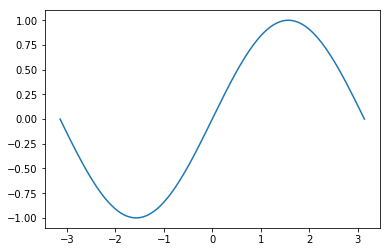

In [154]:
import numpy as np
angle = np.linspace(-np.pi, np.pi, 201)
import matplotlib.pylab as plt
y=np.sin(angle)
print(type(y))
plt.plot(angle,y)

In [155]:
import pandas as pd
values=list()
for looped in range(0,100):
    for i in range(0,len(y)):
        values.append(y[i]);

In [156]:
time_step=list()
for i in range(0,len(values)):
        time_step.append(i);

In [157]:
data = pd.DataFrame(
    {'time_step': time_step,
     'valuea': values,
    })

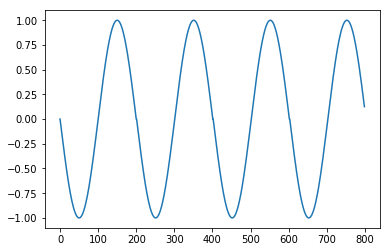

In [161]:
plt.plot(data['time_step'][0:800],data['valuea'][0:800])

In [159]:
series=np.reshape(data['valuea'].values,(np.shape(data['valuea'].values)[0],1))

In [160]:
np.save("series",series)

We have series repeating every once in 200 cycles.

Preparing data for time series

## Cloud Section to upload the data.

In [1]:
import ibm_boto3
from ibm_botocore.client import Config
import os
import json
import warnings
import time

In [135]:
cos_credentials = {
  "apikey": "",
  "cos_hmac_keys": {
    "access_key_id": "",
    "secret_access_key": ""
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/fa381d574e4a999f5fa9dca6b6b90fe7:94201900-eecd-43d2-ad0c-51692cc709b9::",
  "iam_apikey_name": "auto-generated-apikey-14fc88d0-fb45-4b9d-bbf4-ea1eca5df527",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/fa381d574e4a999f5fa9dca6b6b90fe7::serviceid:ServiceId-2eb92714-5e02-48e1-b8cf-d1b31cf204fc",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/fa381d574e4a999f5fa9dca6b6b90fe7:94201900-eecd-43d2-ad0c-51692cc709b9::"
}

api_key = cos_credentials['apikey']
service_instance_id = cos_credentials['resource_instance_id']

In [136]:
# Define endpoint information.
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

In [137]:
# Define the authorization endpoint.
auth_endpoint = 'https://iam.bluemix.net/oidc/token'

In [138]:
# Create a COS resource.
cos = ibm_boto3.resource ('s3',
                         ibm_api_key_id=api_key,
                         ibm_service_instance_id=service_instance_id,
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

In [141]:
# Create buckets.
buckets = ['keras-lstm-data-v5', 'keras-lstm-result-v5']

In [142]:
# Create buckets.
for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "keras-lstm-data-v5"...
Creating bucket "keras-lstm-result-v5"...


In [143]:
# Display a list of created buckets.
print(list(cos.buckets.all()))

[s3.Bucket(name='assignment-bucket'), s3.Bucket(name='keras-lstm-data-v5'), s3.Bucket(name='keras-lstm-result-v5'), s3.Bucket(name='machinelearningproject-donotdelete-pr-bjhorw2eb2wz7k'), s3.Bucket(name='mnist-keras-data-example-v4'), s3.Bucket(name='mnist-keras-results-example-v4')]


In [144]:
# Upload files to the buckets.
bucket_name = buckets[0]
bucket_obj = cos.Bucket(bucket_name)

In [145]:
!pip install wget
link = 'https://github.com/meethariprasad/phd/raw/master/series.npy'

Requirement not upgraded as not directly required: wget in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages


In [146]:
import wget, os

data_dir = 'keras_lstm'

if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

if not os.path.isfile(os.path.join(data_dir, os.path.join(link.split('/')[-1]))):
    wget.download(link, out=data_dir)  
        
!ls keras_lstm

series.npy  series.npz


In [147]:
import wget, os

data_dir = 'keras_lstm'

for filename in os.listdir(data_dir):
    with open(os.path.join(data_dir, filename), 'rb') as data: 
        bucket_obj.upload_file(os.path.join(data_dir, filename), filename)
        print('{} is uploaded.'.format(filename))

series.npz is uploaded.
series.npy is uploaded.


In [148]:
# Display a list of buckets.
for obj in bucket_obj.objects.all():
    print('Object key: {}'.format(obj.key))
    print('Object size (kb): {}'.format(obj.size/1024))

Object key: series.npy
Object size (kb): 157.109375
Object key: series.npz
Object size (kb): 2.0283203125


### Watson Machine Learning Experiment

In [149]:
# Import the libraries.
import urllib3, requests, json, base64, time, os
warnings.filterwarnings('ignore')

In [150]:
wml_credentials = {
  "apikey": "",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:us-south:a/fa381d574e4a999f5fa9dca6b6b90fe7:4277973c-258e-4701-a035-42d54566f2b3::",
  "iam_apikey_name": "auto-generated-apikey-2247a1ae-1b9f-48de-8678-4cb3cc722453",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/fa381d574e4a999f5fa9dca6b6b90fe7::serviceid:ServiceId-0e00fbf7-9a8d-4d4f-b931-7ecd4de1c921",
  "instance_id": "",
  "password": "",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": ""
}

In [151]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [152]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [153]:
# Display the client version number.
print(client.version)

1.0.295


### Create Training Definition

In [154]:
model_definition_metadata = {
            client.repository.DefinitionMetaNames.NAME: "keras-lstm-v2",
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.5",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python3 implementation_keras_lstm_v2.py"
            }

In [155]:
filename_keras='implementation_keras_lstm_v2.zip'

In [156]:
!rm -rf implementation_keras_lstm_v2.zip

if os.path.isfile(filename_keras):
    !ls 'implementation_keras_lstm_v2.zip'
else:
    !wget https://github.com/meethariprasad/phd/raw/master/Watson/Keras-lstm/implementation_keras_lstm_v2.zip
    !ls 'implementation_keras_lstm_v2.zip'

--2018-08-10 11:00:46--  https://github.com/meethariprasad/phd/raw/master/Watson/Keras-lstm/implementation_keras_lstm_v2.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/meethariprasad/phd/master/Watson/Keras-lstm/implementation_keras_lstm_v2.zip [following]
--2018-08-10 11:00:46--  https://raw.githubusercontent.com/meethariprasad/phd/master/Watson/Keras-lstm/implementation_keras_lstm_v2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2085 (2.0K) [application/zip]
Saving to: ‘implementation_keras_lstm_v2.zip’

100%[======================================>] 2,085       --.-K/s   in 0s      

2018-08-10 11:00:46

In [157]:
#Store Definitions in WML Repository
definition_details = client.repository.store_definition(filename_keras, model_definition_metadata)

In [158]:
definition_url = client.repository.get_definition_url(definition_details)
definition_uid = client.repository.get_definition_uid(definition_details)
print(definition_url)

https://us-south.ml.cloud.ibm.com/v3/ml_assets/training_definitions/58dd86c8-bcc9-4cff-b8ea-5d885e5a0054


In [159]:
client.repository.list_definitions()

------------------------------------  -------------  ------------------------  ----------
GUID                                  NAME           CREATED                   FRAMEWORK
58dd86c8-bcc9-4cff-b8ea-5d885e5a0054  keras-lstm-v2  2018-08-10T11:00:57.397Z  tensorflow
a6d74c07-3d7f-44d0-8385-03b3a77dadb9  keras-lstm-v2  2018-08-10T10:54:58.056Z  tensorflow
59559377-0159-4ea6-a597-20bb56b3a061  keras-lstm-v2  2018-08-10T10:46:28.521Z  tensorflow
5b6badd9-c644-4062-ae15-6a2caa870c24  keras-lstm-v2  2018-08-10T10:16:06.920Z  tensorflow
0863e5aa-b9e7-4a1e-bb27-67bc1b5a890e  keras-lstm-v2  2018-08-10T10:15:11.742Z  tensorflow
0304fb2d-c481-4d4f-85a8-91ac27da3724  keras-lstm-v2  2018-08-10T10:13:14.151Z  tensorflow
9509bcc4-5af2-4b2f-84d8-13868bed6cdb  MNIST-CNN      2018-08-09T21:17:33.302Z  tensorflow
59b9cd9c-9fb6-4851-ac9d-ad0d61780fdf  MNIST-MLP      2018-08-09T21:17:31.388Z  tensorflow
1a4482db-b96a-413a-9ae9-0e38be3d2c18  MNIST-CNN      2018-08-09T20:42:42.628Z  tensorflow
d49cd12c-b3

In [160]:
#We need to define Required = Y mandatory to run experiment
client.repository.ExperimentMetaNames.show()

--------------------------  ----  --------
META_PROP NAME              TYPE  REQUIRED
NAME                        str   Y
DESCRIPTION                 str   N
TAGS                        list  N
AUTHOR_NAME                 str   N
EVALUATION_METHOD           str   N
EVALUATION_METRICS          list  N
TRAINING_REFERENCES         list  Y
TRAINING_DATA_REFERENCE     dict  Y
TRAINING_RESULTS_REFERENCE  dict  Y
--------------------------  ----  --------


In [162]:
TRAINING_DATA_REFERENCE = {
                            "connection": {
                                "endpoint_url": service_endpoint,
                                "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                            },
                            "source": {
                                "bucket": buckets[0],
                            },
                            "type": "s3"
}

In [163]:
TRAINING_RESULTS_REFERENCE = {
                                "connection": {
                                    "endpoint_url": service_endpoint,
                                    "access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                    "secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                                },
                                "target": {
                                    "bucket": buckets[1],
                                },
                                "type": "s3"
}

In [164]:
#We need to define Required = Y mandatory to run experiment
client.repository.ExperimentMetaNames.show()

--------------------------  ----  --------
META_PROP NAME              TYPE  REQUIRED
NAME                        str   Y
DESCRIPTION                 str   N
TAGS                        list  N
AUTHOR_NAME                 str   N
EVALUATION_METHOD           str   N
EVALUATION_METRICS          list  N
TRAINING_REFERENCES         list  Y
TRAINING_DATA_REFERENCE     dict  Y
TRAINING_RESULTS_REFERENCE  dict  Y
--------------------------  ----  --------


In [165]:
experiment_metadata = {
            client.repository.ExperimentMetaNames.NAME: "Keras LSTM Experiment",
            #client.repository.ExperimentMetaNames.DESCRIPTION: "KERAS LSTM MODEL",
            #client.repository.ExperimentMetaNames.EVALUATION_METHOD: "multiclass",
            #client.repository.ExperimentMetaNames.EVALUATION_METRICS: ["val_acc"],
            #client.repository.ExperimentMetaNames.EVALUATION_METRICS: [{"name": "val_acc", "maximize": True}],
            client.repository.ExperimentMetaNames.TRAINING_DATA_REFERENCE: TRAINING_DATA_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_RESULTS_REFERENCE: TRAINING_RESULTS_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_REFERENCES: [
                        {
                            "name": "keras_lstm",
                            "training_definition_url": definition_url,
                            "compute_configuration": {"name": "k80x2"}
                            
                        }]
            }

In [166]:
# Store the experiment, and display the experiments uid.
experiment_details = client.repository.store_experiment(meta_props=experiment_metadata)

experiment_uid = client.repository.get_experiment_uid(experiment_details)
print(experiment_uid)

3b1714d3-668e-4f52-9d89-7b00cce26274


In [167]:
client.repository.list_experiments()

------------------------------------  ---------------------  ------------------------
GUID                                  NAME                   CREATED
3b1714d3-668e-4f52-9d89-7b00cce26274  Keras LSTM Experiment  2018-08-10T11:01:36.686Z
13b69de8-906e-4b9a-8dd1-5b2345cbb2a8  Keras LSTM Experiment  2018-08-10T10:55:33.601Z
215ba97b-10c7-4004-b618-128f20706dc4  MNIST experiment       2018-08-09T21:18:49.952Z
------------------------------------  ---------------------  ------------------------


In [70]:
#old_experiment_guid="9607bb06-7e89-41f1-b90c-b574541fb1c5"
#client.repository.delete(old_experiment_guid)

In [ ]:
details = client.repository.get_experiment_details(experiment_uid)
print(details)

Run experiment

In [169]:
# Start the experiment run.
experiment_run_details = client.experiments.run(experiment_uid, asynchronous=True)

In [170]:
experiment_run_uid = client.experiments.get_run_uid(experiment_run_details)
print(experiment_run_uid)

c0f8f503-ca52-4aa7-a82d-b709ce7d2e32


In [183]:
client.experiments.list_runs()

------------------------------------  ------------------------------------  ---------------------  ---------  --------------------
GUID (experiment)                     GUID (run)                            NAME (experiment)      STATE      CREATED
3b1714d3-668e-4f52-9d89-7b00cce26274  c0f8f503-ca52-4aa7-a82d-b709ce7d2e32  Keras LSTM Experiment  completed  2018-08-10T11:01:48Z
13b69de8-906e-4b9a-8dd1-5b2345cbb2a8  afb5260a-6997-4102-8d9c-256a0a1cb7c4  Keras LSTM Experiment  error      2018-08-10T10:55:48Z
215ba97b-10c7-4004-b618-128f20706dc4  fdb1879d-0295-4dee-9048-8c3135f09694  MNIST experiment       completed  2018-08-09T21:19:03Z
------------------------------------  ------------------------------------  ---------------------  ---------  --------------------


In [ ]:
experiment_run_details = client.experiments.get_run_details(experiment_run_uid)
print(experiment_run_details)

In [ ]:
print(json.dumps(experiment_details, indent=2))

In [179]:
client.experiments.get_status(experiment_run_uid)['state']

'completed'

Model

In [181]:
status = client.experiments.get_status(experiment_run_uid)

In [ ]:
#Got the run ID from Watson Environment.
client.training.get_details('training-WWmHAB5ig')

In [193]:
model_uid='training-WWmHAB5ig'
saved_model_details = client.repository.store_model(model_uid, {'name': 'Keras LSTM model'})

In [194]:
model_guid = client.repository.get_model_uid(saved_model_details)
print("Saved model guid: " + model_guid)

Saved model guid: 8bd358fa-dba5-4d8f-913b-d066d8547e49


In [195]:
client.repository.list_models()

------------------------------------  ----------------  ------------------------  --------------
GUID                                  NAME              CREATED                   FRAMEWORK
8bd358fa-dba5-4d8f-913b-d066d8547e49  Keras LSTM model  2018-08-10T12:10:35.621Z  tensorflow-1.5
464eee43-7d28-4471-99b5-7977e3e624fa  MNIST best model  2018-08-09T21:26:20.808Z  tensorflow-1.5
------------------------------------  ----------------  ------------------------  --------------


In [196]:
deployment_details = client.deployments.create(model_guid, name="Keras LSTM deployment")



#######################################################################################

Synchronous deployment creation for uid: '8bd358fa-dba5-4d8f-913b-d066d8547e49' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS...
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='c602e227-e2b2-4395-905e-8eb7d67a419a'
------------------------------------------------------------------------------------------------




In [197]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/4277973c-258e-4701-a035-42d54566f2b3/deployments/c602e227-e2b2-4395-905e-8eb7d67a419a/online


Scoring

In [310]:
import numpy as np
angle = np.linspace(-np.pi, np.pi, 201)
#import matplotlib.pylab as plt
y=np.sin(angle)
#print(type(y))
#plt.plot(angle,y)


# In[4]:


import pandas as pd
values=list()
for looped in range(0,100):
    for i in range(0,len(y)):
        values.append(y[i]);


# In[5]:


time_step=list()
for i in range(0,len(values)):
        time_step.append(i);


# In[6]:


data = pd.DataFrame(
    {'time_step': time_step,
     'valuea': values,
    })


# In[7]:


#plt.plot(data['time_step'][0:800],data['valuea'][0:800])


# In[8]:


series=np.reshape(data['valuea'].values,(np.shape(data['valuea'].values)[0],1))


# We have series repeating every once in 200 cycles.
# 
# Preparing data for time series

# In[9]:


#Normalize Values
from sklearn.preprocessing import MinMaxScaler
#Sin wave b/w -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler_fit=scaler.fit(series)
scaled = scaler_fit.transform(series)
series = pd.DataFrame(scaled)


# During new data incoming, remember to use scaler used above to scale the data.

# In[10]:


window_size = 201

series_s = series.copy()
for i in range(window_size):
    series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)
    
series.dropna(axis=0, inplace=True)


# In[11]:


#series.shape


# In[12]:


nrow = round(0.8*series.shape[0])


# In[13]:


train = series.iloc[:nrow, :]
test = series.iloc[nrow:,:]


# In[14]:


#test.to_csv("time_series_train.csv")
#test.to_csv("time_series_test.csv")


# In[15]:


from sklearn.utils import shuffle
train = shuffle(train)


# In[16]:


train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]


# In[17]:


train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values


# In[18]:


#print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)


# Reshaping the data to match with LSTM

# In[19]:


train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

In [324]:
print(test_X[0:202].shape)
payload_data=test_X[0:202]

(202, 201, 1)


In [ ]:
# Example: scoring_payload = {'fields': ['GENDER','AGE','MARITAL_STATUS','PROFESSION'], 'values': [['M',23,'Single','Student'],['M',55,'Single','Executive']]}
 

In [325]:
scoring_data = {'values': payload_data.tolist()}

In [326]:
predictions = client.deployments.score(scoring_url, scoring_data)
print("Scoring result: " + str(predictions))

Scoring result: {'fields': ['prediction', 'prediction_classes', 'probability'], 'values': [[[-0.9364223480224609], [0], [-0.9364223480224609]], [[-0.9458402395248413], [0], [-0.9458402395248413]], [[-0.9543389081954956], [0], [-0.9543389081954956]], [[-0.9619091749191284], [0], [-0.9619091749191284]], [[-0.9685428738594055], [0], [-0.9685428738594055]], [[-0.9742326736450195], [0], [-0.9742326736450195]], [[-0.9789726138114929], [0], [-0.9789726138114929]], [[-0.9827575087547302], [0], [-0.9827575087547302]], [[-0.9855833053588867], [0], [-0.9855833053588867]], [[-0.9874461889266968], [0], [-0.9874461889266968]], [[-0.9883439540863037], [0], [-0.9883439540863037]], [[-0.9882749319076538], [0], [-0.9882749319076538]], [[-0.9872381687164307], [0], [-0.9872381687164307]], [[-0.9852336645126343], [0], [-0.9852336645126343]], [[-0.982262134552002], [0], [-0.982262134552002]], [[-0.978325366973877], [0], [-0.978325366973877]], [[-0.9734258651733398], [0], [-0.9734258651733398]], [[-0.9675668

In [328]:
test_y[0:202].shape

(202,)

In [329]:
predictions

{'fields': ['prediction', 'prediction_classes', 'probability'],
 'values': [[[-0.9364223480224609], [0], [-0.9364223480224609]],
  [[-0.9458402395248413], [0], [-0.9458402395248413]],
  [[-0.9543389081954956], [0], [-0.9543389081954956]],
  [[-0.9619091749191284], [0], [-0.9619091749191284]],
  [[-0.9685428738594055], [0], [-0.9685428738594055]],
  [[-0.9742326736450195], [0], [-0.9742326736450195]],
  [[-0.9789726138114929], [0], [-0.9789726138114929]],
  [[-0.9827575087547302], [0], [-0.9827575087547302]],
  [[-0.9855833053588867], [0], [-0.9855833053588867]],
  [[-0.9874461889266968], [0], [-0.9874461889266968]],
  [[-0.9883439540863037], [0], [-0.9883439540863037]],
  [[-0.9882749319076538], [0], [-0.9882749319076538]],
  [[-0.9872381687164307], [0], [-0.9872381687164307]],
  [[-0.9852336645126343], [0], [-0.9852336645126343]],
  [[-0.982262134552002], [0], [-0.982262134552002]],
  [[-0.978325366973877], [0], [-0.978325366973877]],
  [[-0.9734258651733398], [0], [-0.973425865173339

In [330]:
prediction_frame=pd.DataFrame(columns=(predictions['fields']))
prediction_frame

,prediction,prediction_classes,probability


In [342]:
for i in range(0,len(predictions['values'])):
    if i==0:
        prediction_data=np.transpose(np.array(predictions['values'][i]))
    if i>0:
        temp=np.transpose(np.array(predictions['values'][i]))
        prediction_data=np.append(pred_data,temp,axis=0)

In [348]:
prediction_dataframe=pd.DataFrame(prediction_data,columns=(predictions['fields']))
prediction_dataframe.iloc[:,0:1].shape

(203, 1)

In [349]:
actual=test_y[0:203]
actuals_dataframe=pd.DataFrame(actual,columns=['actual'])
actuals_dataframe.shape

(203, 1)

In [351]:
predict_actual_df=pd.concat([prediction_dataframe.iloc[:,0:1], actuals_dataframe], axis=1)
predict_actual_df.shape

(203, 2)

In [354]:
#We have scaled the data inside -1 to 1 to again -1 to 1. May not make much sense in this example, but for other real data we might want to transform and re-transform.
scaler_fit.inverse_transform(predict_actual_df).shape

(203, 2)

In [359]:
predict_actual_df.columns

Index(['prediction', 'actual'], dtype='object')

We will plot and see the prediction and actual. We can see that it is doing well on test data.

In [373]:
import plotly as pltly
import plotly.tools as tls

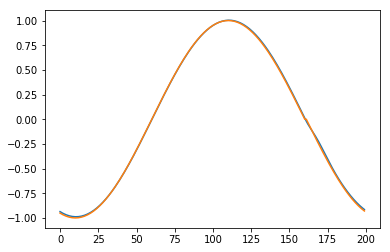

In [383]:
import matplotlib.pyplot as plt
mat_plt_plt=plt.figure()
plt.plot(predict_actual_df['prediction'][0:200])
plt.plot(predict_actual_df['actual'][0:200])

How about zooming in and see how close the predicted and actual plots are?

In [390]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [391]:
plotly_fig = tls.mpl_to_plotly(mat_plt_plt)
iplot(plotly_fig, filename='myplot')

Statistically Checking MSE,RMSE,R Squared on test data.

In [396]:
from sklearn.metrics import mean_squared_error
from math import sqrt
meanSquaredError=mean_squared_error(predict_actual_df['actual'], predict_actual_df['prediction'])
print("MSE:", meanSquaredError)
rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)
from sklearn.metrics import r2_score
print("R Squared:",r2_score(predict_actual_df['actual'], predict_actual_df['prediction']) )

MSE: 0.000103172216097
RMSE: 0.010157372499669444
R Squared: 0.999794281188


## Next steps

Given 201 time steps, the model is predicting 202 value.

Some realtime steps are missing though.

Model is trained once and used without updates. 

There is a possibility that as and when future data arrives, the accuracy of the model reduces beond acceptable level.

One way to ensure model quality is within accceptable level levels is, predict for next value, then when the acctual next data arrives check the difference between actual/predicted and check the model quality. If the model tolerance below the acceptable limit, then retain the model based on new actual values and check if the model quality is increased. If it is not with tolerance limit, set up a alert to data scientist for further research in to model quality. Stakeholders also need to be informed about tolerance level dropped, ensuring they don't infer based on below threshold model. Best way is to put the model quality in dashboard accessible for both stakeholders and data scientists.

The answer for above can be explored further in continuous learning.




